This notebook examines the results from three modifications to the previous MESA inlists

* a new set of wind models
* a new stopping condition to avoid runaway critically rotating stars
* tracking the chemical mixing timescale

In [1]:
# nb_id is used to identify this notebook's output files (i.e., figures) if there are any
# it should match the first two digits in the notebook's title
nb_id = 13

### Prelude

In [27]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

import astropy.units as u
import astropy.constants as ct
from astropy.cosmology import WMAP9
from scipy.signal import find_peaks
from scipy.integrate import simpson

import mesa_reader as mr
import mesaPlot as mp
import tulips as tp

import sys
sys.path.append('..')
from src.constants import (Z_SUN, MASS_U, PERIOD_U, AGE_U, SMA_U, RADIUS_U, TEMP_U, LUMINOSITY_U, 
                           T_H)
from src.star import (eggleton_rl1_radius, marchant_l2_radius, a_from_p, p_from_a, tau_kh, fix_unit,
                      ToutMassLuminosityRelation, ToutMassRadiusRelation, 
                      HurleyMassLuminosityRelation, HurleyMassRadiusRelation)


In [3]:
ROOT = Path.cwd().parent
FIGURE_FOLDER = Path(f'./output/nb{nb_id}/figures')
FIGURE_FOLDER.mkdir(parents=True, exist_ok=True)

In [4]:
PROJECT_FOLDER = ROOT/'mesa/sse_wind_test'

In [5]:
plt.style.use('./plotstyle.mplstyle')

In [6]:
def tau_es1(m, r, tau_kh, omega):
    m = fix_unit(m, MASS_U)
    r = fix_unit(r, RADIUS_U)
    tau_kh = fix_unit(tau_kh, u.yr)
    omega *= u.s**-1
    tau_es = tau_kh * ct.G * m / (omega**2 * r**3)   
    return tau_es.to(u.yr).value
    

In [7]:
def savefig(fig, fname):
    fname = f'nb{nb_id}_{fname}'
    plt.savefig(FIGURE_FOLDER/(fname+'.png'), bbox_inches='tight')
    plt.savefig(FIGURE_FOLDER/(fname+'.pdf'), bbox_inches='tight')
    plt.savefig(FIGURE_FOLDER/(fname+'.eps'), bbox_inches='tight')

### References

Gottlieb, O., Renzo, M., Metzger, B. D., Goldberg, J. A. & Cantiello, M., *She's got her mother's hair: end-to-end collapsar simulations unveil the origin of black holes' magnetic field*, 2024, [arXiv:2407.16745](https://ui.adsabs.harvard.edu/abs/2024arXiv240716745G/abstract)  
Nugis, T. & Lamers, H. J. G. L. M., *Mass-loss rates of Wolf-Rayet stars as a function of stellar parameters*, 2000, [A&A 360, 227](https://ui.adsabs.harvard.edu/abs/2000A%26A...360..227N/abstract)  
Vink, J. S., de Koter, A. & Lamers, H. J. G. L. M., *New theoretical mass-loss rates of O and B Stars*, 2000, [A&A, 362, 295](https://ui.adsabs.harvard.edu/abs/2000A%26A...362..295V/abstract)

### Definitions

In [9]:
mix_dict = dict(
    radiative=-1,
    none=0,
    convective=1,
    overshoot=2,
    semiconvective=3,
    thermohaline=4,
    rotation=5,
    rayleigh_taylor=6,
    minimum=7,
    anonymous=8,
    leftover=9,
    phase_sep=10
    )
mix_dict = {v: k for k, v in mix_dict.items()}

In [10]:
def get_model_dict(grid_folder):
    d = dict()
    for model_folder in grid_folder.glob('m*_w*'):
        if model_folder.suffix == '.log':
            continue
        m, w = model_folder.name.replace('d', 'e').split('_')        
        m = f'{float(m.lstrip("m")):.1f}'
        w = float(w.lstrip('w'))
        p = 2*np.pi / w / (60*60*24)
        p = f'{p:.2f}'
        if m not in d.keys():
            d[m] = dict()
        d[m][p] = model_folder
    return d

In [11]:
def monitor(w, h, axes, c, col_indices=[0, 1, 2, 3, 4, 5, 6]):
    #fig, axes = plt.subplots(1, 7, figsize=(36, 4), sharex=True)
    #fig.subplots_adjust(wspace=0.5)

    omg_ax, wct_ax, vrt_ax, mss_ax, rad_ax, lum_ax, he4_ax = col_indices 

    axes[omg_ax].plot(h.star_age/1e6, h.surf_avg_v_rot/(2*np.pi*h.radius*u.Rsun.to(u.km)/(2*np.pi)), lw=1, c=c)     
    axes[vrt_ax].plot(h.star_age/1e6, h.surf_avg_v_rot, lw=1, c=c)     
    axes[rad_ax].plot(h.star_age/1e6, h.radius, lw=1, c=c)    
    axes[wct_ax].plot(h.star_age/1e6, h.surf_avg_omega_div_omega_crit, lw=1, c=c)        
    axes[mss_ax].plot(h.star_age/1e6, h.star_mass, lw=1, c=c)    
    axes[lum_ax].plot(h.star_age/1e6, h.log_L, lw=1, c=c)    
    axes[he4_ax].plot(h.star_age/1e6, h.surface_he4, lw=1, c=c)    
    axes[he4_ax].plot(h.star_age/1e6, h.center_h1, lw=1, c=c, ls='--') 
    
    i_critrot_peaks = find_peaks(h.surf_avg_omega_div_omega_crit, height=1, distance=100, prominence=0.1)[0]
    t_critrot_peaks= h.star_age[i_critrot_peaks]/1e6
    for t in t_critrot_peaks:
        # don't plot peaks (too many in one panel)
        continue
        for ax in axes:
            y0, y1 = ax.get_ylim()
            ax.vlines(t, 0, y1, lw=1, color='k', ls='-')
            try:
                ax.vlines(h.star_age[1500]/1e6, 0, y1, lw=1, color='k', ls='--')
            except IndexError:
                pass
            ax.set_ylim(y0, y1)
            
    #axes[omg_ax].set_ylabel('$\\Omega$')
    #axes[vrt_ax].set_ylabel('$v_\\mathrm{rot}/\\mathrm{km}\\,\\mathrm{s}^{-1}$')
    #axes[rad_ax].set_ylabel('$R/\\mathrm{R}_\\odot$')
    #axes[wct_ax].set_ylabel('$\\Omega/\\Omega_\\mathrm{crit}$')
    #axes[mss_ax].set_ylabel('$M/\\mathrm{M}_\\odot$')
    #axes[lum_ax].set_ylabel('$L/\\mathrm{L}_\\odot$')
    #axes[he4_ax].set_ylabel('S.He4 / C. H1')
    
    if h.center_h1[-1] < 1e-7:
        status = 'DONE'
    else:
        status = 'RUNNING'
        
    p = 2 * np.pi / float(w) / (24*60*60)
    handle = Line2D((-1, -1), (-1, -1), linestyle='-', color=c, 
                    label=f'${p:.2f}\\,\\mathrm{{d}}$ ({np.log10(h.center_h1[-1]):.1f}, {len(h.star_age)} steps)')
    #axes[3].text(0.5, 1.1, f'$m={m:.1f}\\,\\mathrm{{M}}_\\odot, P={p:.2f}\\,\\mathrm{{d}}, \\Omega={w:.1e}\\,\\mathrm{{rad}}\\,\\mathrm{{s}}^{{-1}},$ {len(h.star_age)} steps ({status})', 
    #             rotation=0, va='center', ha='right', fontsize=28, transform=axes[3].transAxes)   
    
    return axes, handle

In [12]:
def get_model_folder(model_id, verbose=True):
    matches = list(PROJECT_FOLDER.glob(f'{model_id}_*'))
    
    if len(matches) > 1:
        if verbose:
            print('\n'.join((
                f'Multiple matches for id {model_id} found in {PROJECT_FOLDER}:',
                *[str(match) for match in matches]
            )))
        return
    elif len(matches) != 0:
        match = matches[0]
        if verbose:
            print(f'Found match {match}')
        return match
    else:
        if verbose:
            print(f'No matches found in {PROJECT_FOLDER}')
        return           

In [13]:
def mesareader_operator(expression):
    operations = ['+', '-', '*', '/', '(', ')']
    
    mr_expression = ''
    attr = ''
    char_i = 0
    while char_i < len(expression):
        char = expression[char_i]
        if char not in operations:
            mr_expression += f'h.__getattr__("{char}'
        else:
            mr_expression += f'{char}h.__getattr__("'
        char_i += 1
        char = expression[char_i]
        while char not in operations+['']:
            attr += char
            char_i += 1
            try:
                char = expression[char_i]
            except IndexError:
                char = ''
        attr = f'{attr}"){char}'
        mr_expression += attr
        attr = ''
        char_i += 1
            
    return mr_expression

In [14]:
def history_plot(ax, model_dict_list, model_styles, model_labels, x, y, invert_xaxis, invert_yaxis, title=False,
                 label_period=True):
    base_dict = model_dict_list[0]
    all_paths = [base_dict[k1][k2] for k1 in base_dict.keys() for k2 in base_dict[k1].keys()] 
    
    _c = 1
    handles = []
    for m_key in base_dict.keys():
        base_p_dict = base_dict[m_key]
        p_keys_sort = np.argsort(np.float64(np.array(list(base_p_dict.keys()))))
        p_keys = np.array(list(base_p_dict.keys()))[p_keys_sort]
        m = float(m_key)
        for p_key in p_keys:
            p = float(p_key)
            c = cm.jet(_c/len(all_paths))
            if label_period:
                label = f'${p:.2f}\\,\\mathrm{{d}}$'
            else:
                label = None
            handles.append(Line2D([], [], ls='-', color=c, label=label))
                        
            for model_dict, ls in zip(model_dict_list, model_styles):
                model_path = model_dict[m_key][p_key]    
                h = mr.MesaData(str(model_path/'LOGS/history.data'))
                x_data = eval(mesareader_operator(x))
                y_data = eval(mesareader_operator(y))
                ax.plot(x_data, y_data, ls=ls, color=c, lw=1)
                
            _c += 1
                
    if invert_xaxis:
        ax.invert_xaxis()
    if invert_yaxis:
        ax.invert_yaxis()
    
    if title:
        ax.set_title(model_labels[0], fontsize=20)
    else:
        for ls, label in zip(model_styles, model_labels):
            handles.append(Line2D([], [], color='k', ls=ls, label=label))
    ax.legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(1, 1))
    
    return ax

## Wind prescriptions

In [15]:
ZSUN = 0.014

In [16]:
def _sanders_winds(l, z):
    logz = np.log10(z/ZSUN)
    alpha = 0.32 * logz + 1.4
    l0 = 10.**(-0.87*logz + 5.06)
    mdot10 = 10.**(-0.75*logz - 4.06)
    
    if l < l0:
        log_power_term = 0
    else:
        log_power_term = np.log10(l/l0) ** alpha
        
    w = mdot10 * log_power_term * (l/(10*l0))**0.75
    
    return w

def _vink2017_winds(l, z):
    log_mdot = - 13.3 + 1.36*np.log10(l) + 0.61*np.log10(z/ZSUN)
    return 10.**log_mdot

def _vink2001_winds(l, t, m, z):
    Teff_jump = 1e3*(61.2 + 2.59*(-13.636 + 0.889*np.log10(z/ZSUN)))
    
    if t > 27.5e3:
        a = 1
    elif t < 22.5e3:
        a = 0
    else:
        dt = 100
        if t > Teff_jump + dt:
            a = 1
        elif t < Teff_jump - dt:
            a = 0
        else:
            a = (t - (Teff_jump - dt)) / (2*dt)
    
    if a > 0:
        vinf_div_vesc = 2.6
        vinf_div_vesc = vinf_div_vesc * (z/ZSUN)**0.13
        log_mdot = (
            - 6.697
            + 2.194 * np.log10(l/1e5)
            - 1.313 * np.log10(m/3e1)  
            - 1.226 * np.log10(vinf_div_vesc/2e0)              
            + 0.933 * np.log10(t/4e4) 
            - 10.92 * np.log10(t/4e4)**2
            + 0.85 * np.log10(z/ZSUN)
            )
        mdot1 = 10.**log_mdot
    else:
        mdot1 = 0
        
    if a < 1:
        vinf_div_vesc = 1.3    
        vinf_div_vesc = vinf_div_vesc * (z/ZSUN)**0.13
        log_mdot = (
            - 6.688 
            + 2.210 * np.log10(l/1e5) 
            - 1.339 * np.log10(m/3e1) 
            - 1.601 * np.log10(vinf_div_vesc/2)
            + 1.07 * np.log10(t/2e4) 
            + 0.85 * np.log10(z/ZSUN)
            )
        mdot2 = 10.**log_mdot
    else:
        mdot2 = 0
        
    w = a*mdot1 + (1-a)*mdot2  
    return w


In [17]:
vink2001_winds = np.vectorize(_vink2001_winds)
vink2017_winds = np.vectorize(_vink2017_winds)
sanders_winds = np.vectorize(_sanders_winds)

In [18]:
def _winds(l, t, m, z, y):
    
    v01 = vink2001_winds(l, t, m, z)
    v17 = vink2017_winds(l, z)
    s23 = sanders_winds(l, z)
    
    he_w = max(v17, s23)
    
    if y < 0.4:
        y_weight = 0
    elif y < 0.7:
        y_weight = (y - 0.4)/0.3
    else:
        y_weight = 1
        
    w = y_weight * he_w + (1-y_weight) * v01
    
    return w
    

In [19]:
winds = np.vectorize(_winds)

In [20]:
def normarr(arr):
    return (arr-min(arr))/(max(arr)-min(arr))

### Analysis

In [21]:
model_ids = ['10']
model_folders = np.array([get_model_folder(id) for id in model_ids])
model_dicts = np.array([get_model_dict(folder) for folder in model_folders])
model_labels = np.array([
    '$Z=Z_\\odot/10,\\mathrm{Y}^\\mathrm{surf}_0=0.4,\\mathrm{Y}^\\mathrm{surf}_1=0.7$, He Core Exh.',
])

Found match /mnt/home/ldesa/repos/cher/mesa/sse_wind_test/10_m65_01_zsun_04y0_03dy_HeExh


In [22]:
print('Available models:')
for i in range(len(model_ids)):
    print(f'\t{model_folders[i]}:')
    keys1 = list(model_dicts[i].keys())
    keys1 = np.array(keys1)[np.argsort([float(key) for key in keys1])]
    for key1 in keys1:
        keys2 = list(model_dicts[i][key1].keys())
        keys2 = np.array(keys2)[np.argsort([float(key) for key in keys2])]
        print(f'\t\t(m1/msun) {key1}:')
        for key2 in keys2:
            print(f'\t\t\t(p_orb/d) {key2}')

Available models:
	/mnt/home/ldesa/repos/cher/mesa/sse_wind_test/10_m65_01_zsun_04y0_03dy_HeExh:
		(m1/msun) 65.0:
			(p_orb/d) 0.80
			(p_orb/d) 1.00
			(p_orb/d) 1.19
			(p_orb/d) 1.40
			(p_orb/d) 1.82
			(p_orb/d) 2.20


## Scatter plots

In [46]:
test_case = model_dicts[0]['65.0']['0.80']
h = mr.MesaData(str(test_case/'LOGS/history.data'))
logs  = mr.MesaLogDir(str(test_case/'LOGS'))
profile_numbers = logs.profile_numbers

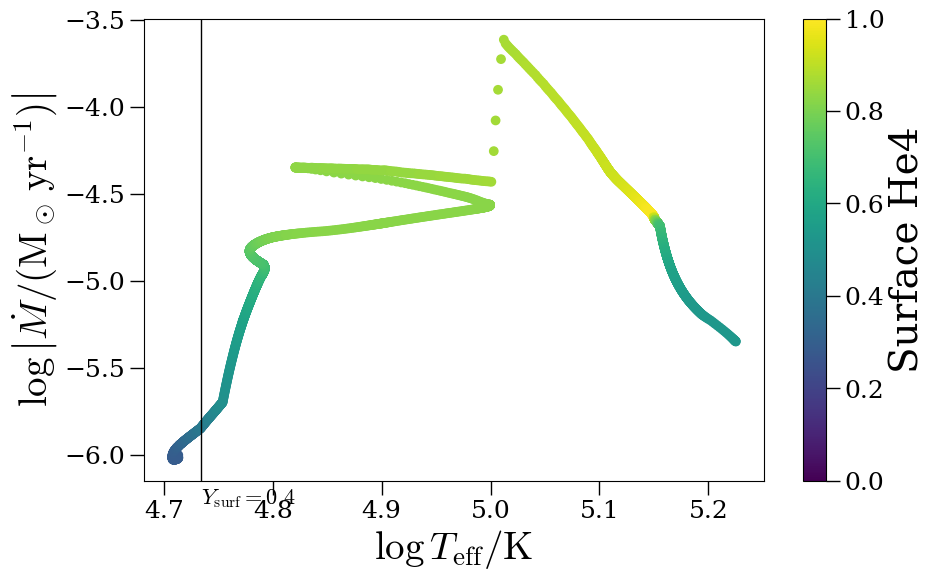

In [47]:
fig, ax = plt.subplots(figsize=(10, 6))

x = h.log_Teff
zams_i = np.where(h.surf_avg_omega_div_omega_crit>0)[0][0]
he04_i = np.where(h.surface_he4 >= 0.4)[0][0]
#he07_i = np.where(h.surface_he4 >= 0.7)[0][0]
c = cm.viridis(h.surface_he4[zams_i:])
#he07_i = np.where(h.surface_he4 >= 0.7)[0][0]

#ax.plot(x, normarr(h.star_mass), 'k-', lw=1, label='normalized $\\log M$')
#ax.plot(x, normarr(h.radius), 'r-', lw=1, label='normalized $\\log R$')
#ax.plot(x, h.surface_he4, 'g-', lw=1, label='Surf. He4')
#ax.plot(x, h.center_h1, 'g--', lw=1, label='Center. H1')
#ax.plot(x, h.surf_avg_omega_div_omega_crit, 'b-', lw=1, label='$\\Omega/\\Omega_\\mathrm{c}$')
ax.scatter(x[zams_i:], h.log_abs_mdot[zams_i:], c=c, label='normalized $\\log \\dot{M}$')

ylim = ax.get_ylim()
ax.vlines(x[he04_i], *ylim, color='k', ls='-', lw=1)
ax.text(x[he04_i], -6.25, '$Y_\\mathrm{surf}=0.4$', ha='left', va='center', transform=ax.transData,
        fontsize=16)
#ax.vlines(x[he07_i], *ylim, color='k', ls='-', lw=1)
#ax.text(x[he07_i], -6.25, '$Y_\\mathrm{surf}=0.7$', ha='left', va='center', transform=ax.transData,
        #fontsize=16)
ax.set_ylim(*ylim)

#ax.hlines(0.4, 0, 3.5, color='k', ls='--', lw=1)
#ax.hlines(0.7, 0, 3.5, color='k', ls='--', lw=1)

ax.set_xlabel('$\\log T_\\mathrm{eff}/\\mathrm{K}$')
ax.set_ylabel('$\\log\left|\dot{M}/(\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1})\\right|$')

#ax.legend(ncol=3, loc='lower left', bbox_to_anchor=(0,1))
cb = fig.colorbar(ScalarMappable(Normalize(vmin=0, vmax=1), cmap=cm.viridis), ax=ax)
cb.set_label('Surface He4')


#ax.set_xlim(0, 1)
#ax.set_yscale('log')
#ax.invert_yaxis()

#ax.set_yscale('log')

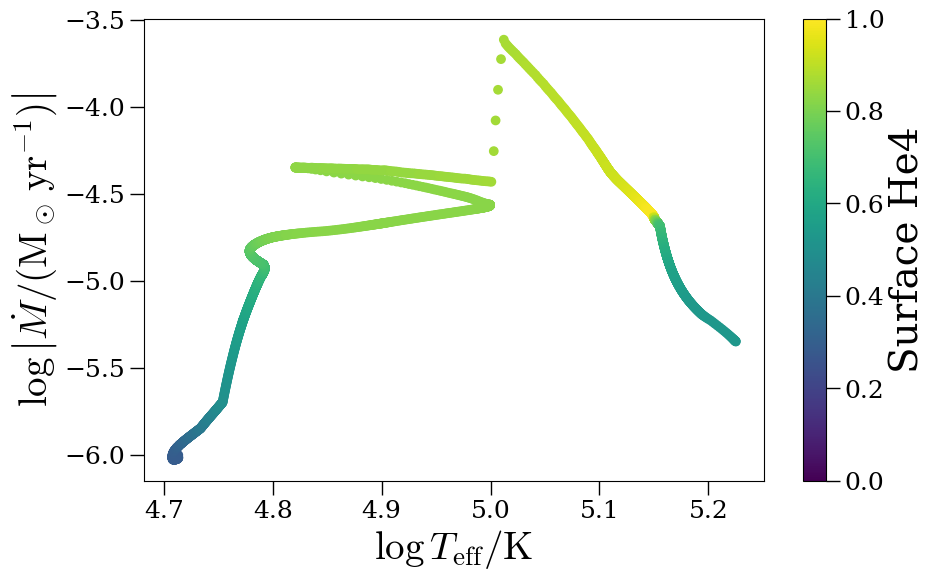

In [48]:
fig, ax = plt.subplots(figsize=(10, 6))

x = h.log_Teff
zams_i = np.where(h.surf_avg_omega_div_omega_crit>0)[0][0]
#he04_i = np.where(h.surface_he4 >= 0.4)[0][0]
#he07_i = np.where(h.surface_he4 >= 0.7)[0][0]
c = cm.viridis(h.surface_he4[zams_i:])
#he07_i = np.where(h.surface_he4 >= 0.7)[0][0]

#ax.plot(x, normarr(h.star_mass), 'k-', lw=1, label='normalized $\\log M$')
#ax.plot(x, normarr(h.radius), 'r-', lw=1, label='normalized $\\log R$')
#ax.plot(x, h.surface_he4, 'g-', lw=1, label='Surf. He4')
#ax.plot(x, h.center_h1, 'g--', lw=1, label='Center. H1')
#ax.plot(x, h.surf_avg_omega_div_omega_crit, 'b-', lw=1, label='$\\Omega/\\Omega_\\mathrm{c}$')
ax.scatter(x[zams_i:], h.log_abs_mdot[zams_i:], c=c, label='normalized $\\log \\dot{M}$')

ylim = ax.get_ylim()
#ax.vlines(x[he04_i], *ylim, color='k', ls='-', lw=1)
#ax.text(x[he04_i], -6.25, '$Y_\\mathrm{surf}=0.4$', ha='left', va='center', transform=ax.transData,
#        fontsize=16)
#ax.vlines(x[he07_i], *ylim, color='k', ls='-', lw=1)
#ax.text(x[he07_i], -6.25, '$Y_\\mathrm{surf}=0.7$', ha='left', va='center', transform=ax.transData,
        #fontsize=16)
ax.set_ylim(*ylim)

#ax.hlines(0.4, 0, 3.5, color='k', ls='--', lw=1)
#ax.hlines(0.7, 0, 3.5, color='k', ls='--', lw=1)

ax.set_xlabel('$\\log T_\\mathrm{eff}/\\mathrm{K}$')
ax.set_ylabel('$\\log\left|\dot{M}/(\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1})\\right|$')

#ax.legend(ncol=3, loc='lower left', bbox_to_anchor=(0,1))
cb = fig.colorbar(ScalarMappable(Normalize(vmin=0, vmax=1), cmap=cm.viridis), ax=ax)
cb.set_label('Surface He4')


#ax.set_xlim(0, 1)
#ax.set_yscale('log')
#ax.invert_yaxis()

#ax.set_yscale('log')

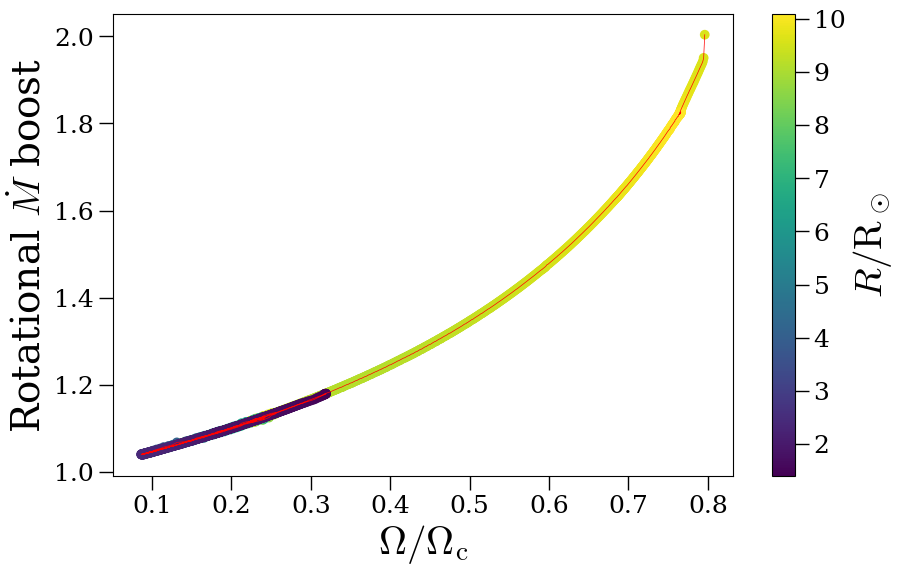

In [49]:
fig, ax = plt.subplots(figsize=(10, 6))

i_start = zams_i
i_end = -1
i_step = 1
cmap = cm.viridis

y = h.rotational_mdot_boost[i_start:i_end:i_step]
x = h.surf_avg_omega_div_omega_crit[i_start:i_end:i_step]
cdata = h.radius[i_start:i_end:i_step]
c = cmap(normarr(cdata))

ax.scatter(x, y, c=c, alpha=1)
ax.plot(x, y, c='r', lw=0.5, alpha=1)
ax.set_xlabel('$\\Omega/\\Omega_\\mathrm{c}$')
ax.set_ylabel('Rotational $\\dot{M}$ boost')

cb = fig.colorbar(ScalarMappable(Normalize(vmin=min(cdata), vmax=max(cdata)), cmap=cmap), ax=ax)
cb.set_label('$R/\\mathrm{R}_\\odot$')


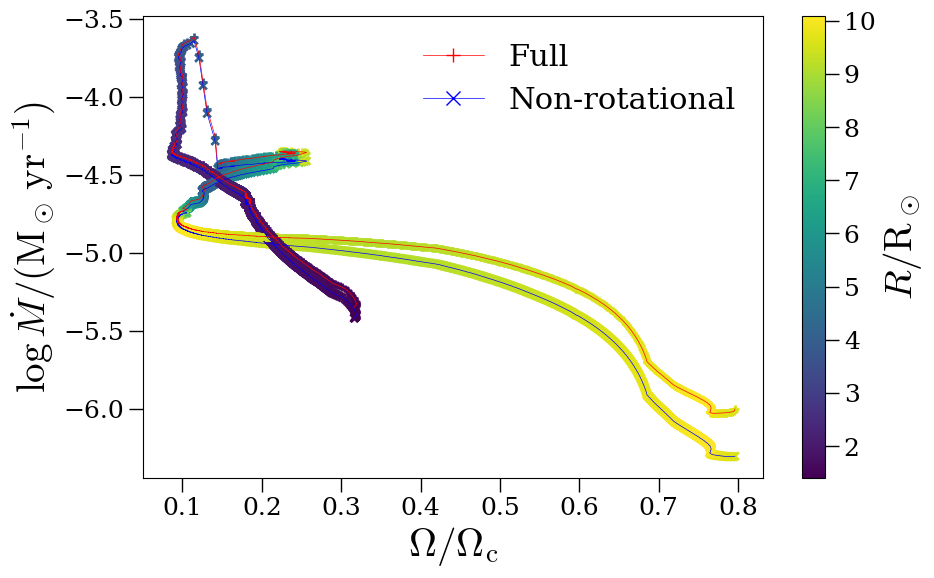

In [50]:
fig, ax = plt.subplots(figsize=(10, 6))

i_start = zams_i
i_end = -1
i_step = 1
cmap = cm.viridis

y1 = np.log10(10**h.log_abs_mdot[i_start:i_end:i_step]/h.rotational_mdot_boost[i_start:i_end:i_step])
y2 = np.log10(10**h.log_abs_mdot[i_start:i_end:i_step])#-10**h.log_abs_mdot[i_start:i_end:i_step]/h.rotational_mdot_boost[i_start:i_end:i_step])
x = h.surf_avg_omega_div_omega_crit[i_start:i_end:i_step]
cdata = h.radius[i_start:i_end:i_step]
c = cmap(normarr(cdata))

ax.scatter(x, y1, c=c, marker='x', alpha=1, s=30)
ax.plot(x, y1, c='b', lw=0.5, alpha=1)
ax.scatter(x, y2, c=c, marker='+', alpha=1, s=30)
ax.plot(x, y2, c='r', lw=0.5, alpha=1)
ax.set_xlabel('$\\Omega/\\Omega_\\mathrm{c}$')
ax.set_ylabel('$\\log\\dot{M}/(\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1})$')

cb = fig.colorbar(ScalarMappable(Normalize(vmin=min(cdata), vmax=max(cdata)), cmap=cmap), ax=ax)
cb.set_label('$R/\\mathrm{R}_\\odot$')

handles = []
handles.append(Line2D([], [], color='r', ls='-', lw=0.5, marker='+', ms=10, label='Full'))
handles.append(Line2D([], [], color='b', ls='-', lw=0.5, marker='x', ms=10, label='Non-rotational'))
ax.legend(handles=handles, frameon=False)


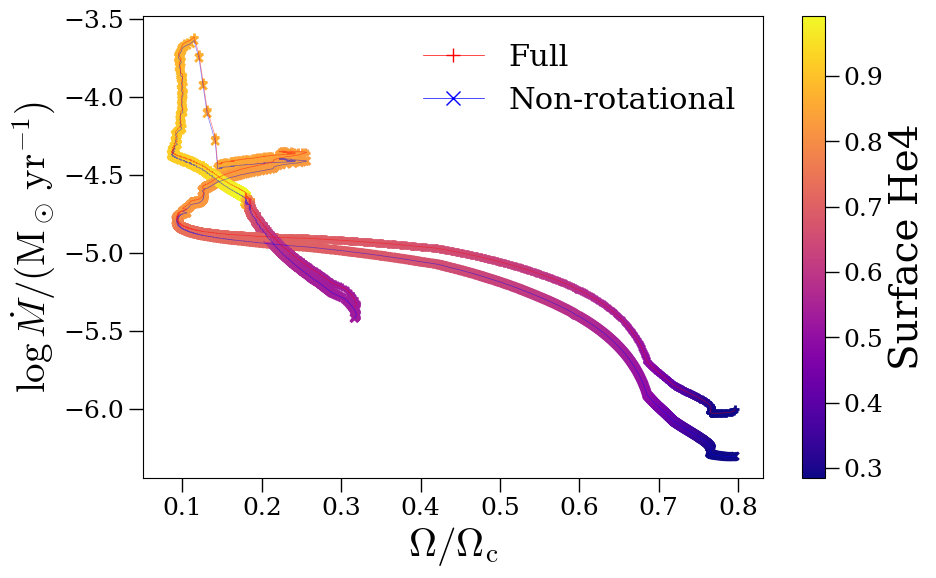

In [51]:
fig, ax = plt.subplots(figsize=(10, 6))

i_start = zams_i
i_end = -1
i_step = 1
cmap = cm.plasma

y1 = np.log10(10**h.log_abs_mdot[i_start:i_end:i_step]/h.rotational_mdot_boost[i_start:i_end:i_step])
y2 = np.log10(10**h.log_abs_mdot[i_start:i_end:i_step])#-10**h.log_abs_mdot[i_start:i_end:i_step]/h.rotational_mdot_boost[i_start:i_end:i_step])
x = h.surf_avg_omega_div_omega_crit[i_start:i_end:i_step]
cdata = h.surface_he4[i_start:i_end:i_step]
c = cmap(normarr(cdata))
he04_i = np.where(h.surface_he4 <= 0.4)[0][0]

ax.scatter(x, y1, c=c, marker='x', alpha=1, s=30)
ax.plot(x, y1, c='b', lw=0.5, alpha=0.5)
ax.scatter(x, y2, c=c, marker='+', alpha=1, s=30)
ax.plot(x, y2, c='r', lw=0.5, alpha=0.5)

ax.set_xlabel('$\\Omega/\\Omega_\\mathrm{c}$')
ax.set_ylabel('$\\log\\dot{M}/(\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1})$')

cb = fig.colorbar(ScalarMappable(Normalize(vmin=min(cdata), vmax=max(cdata)), cmap=cmap), ax=ax)
cb.set_label('Surface He4')

handles = []
handles.append(Line2D([], [], color='r', ls='-', lw=0.5, marker='+', ms=10, label='Full'))
handles.append(Line2D([], [], color='b', ls='-', lw=0.5, marker='x', ms=10, label='Non-rotational'))
ax.legend(handles=handles, frameon=False)


In [53]:
mm = mp.MESA()
mm.loadHistory(f=str(model_dicts[0]['65.0']['0.80']/'LOGS'))
#mm.scrubHistory()

/mnt/home/ldesa/venvdir/cher/lib/python3.10/site-packages/mesaPlot-2.0.8-py3.10.egg/mesaPlot/file_reader.py:308: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/mnt/home/ldesa/venvdir/cher/lib/python3.10/site-packages/mesaPlot-2.0.8-py3.10.egg/mesaPlot/file_reader.py:308: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/mnt/home/ldesa/venvdir/cher/lib/python3.10/site-packages/mesaPlot-2.0.8-py3.10.egg/mesaPlot/file_reader.py:308: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a valu

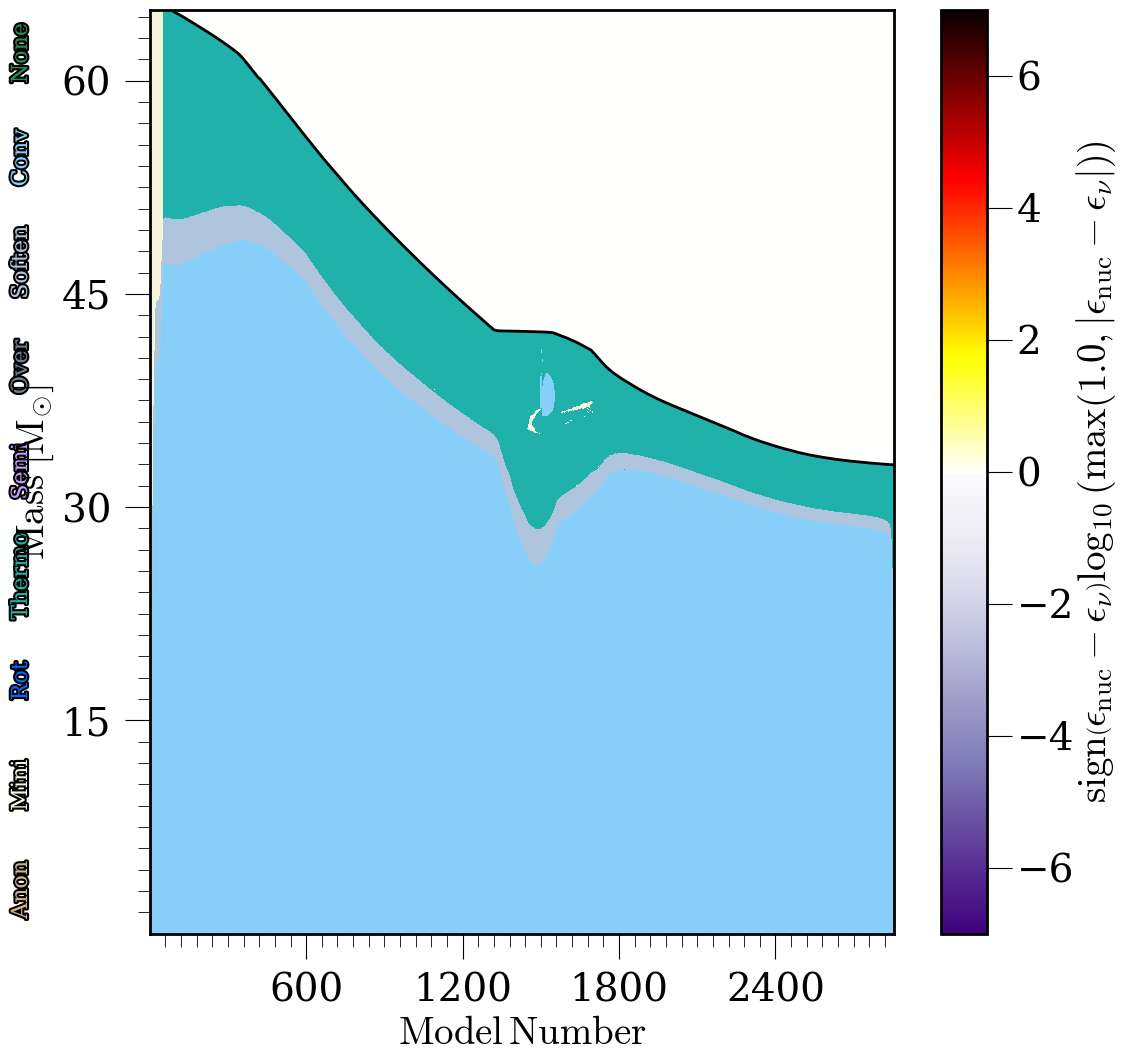

In [54]:
p = mp.plot()
p.plotKip(mm)

#### Internal rotation

In [55]:
test_case = model_dicts[0]['65.0']['0.80']
h = mr.MesaData(str(test_case/'LOGS/history.data'))
logs  = mr.MesaLogDir(str(test_case/'LOGS'))
profile_numbers = logs.profile_numbers

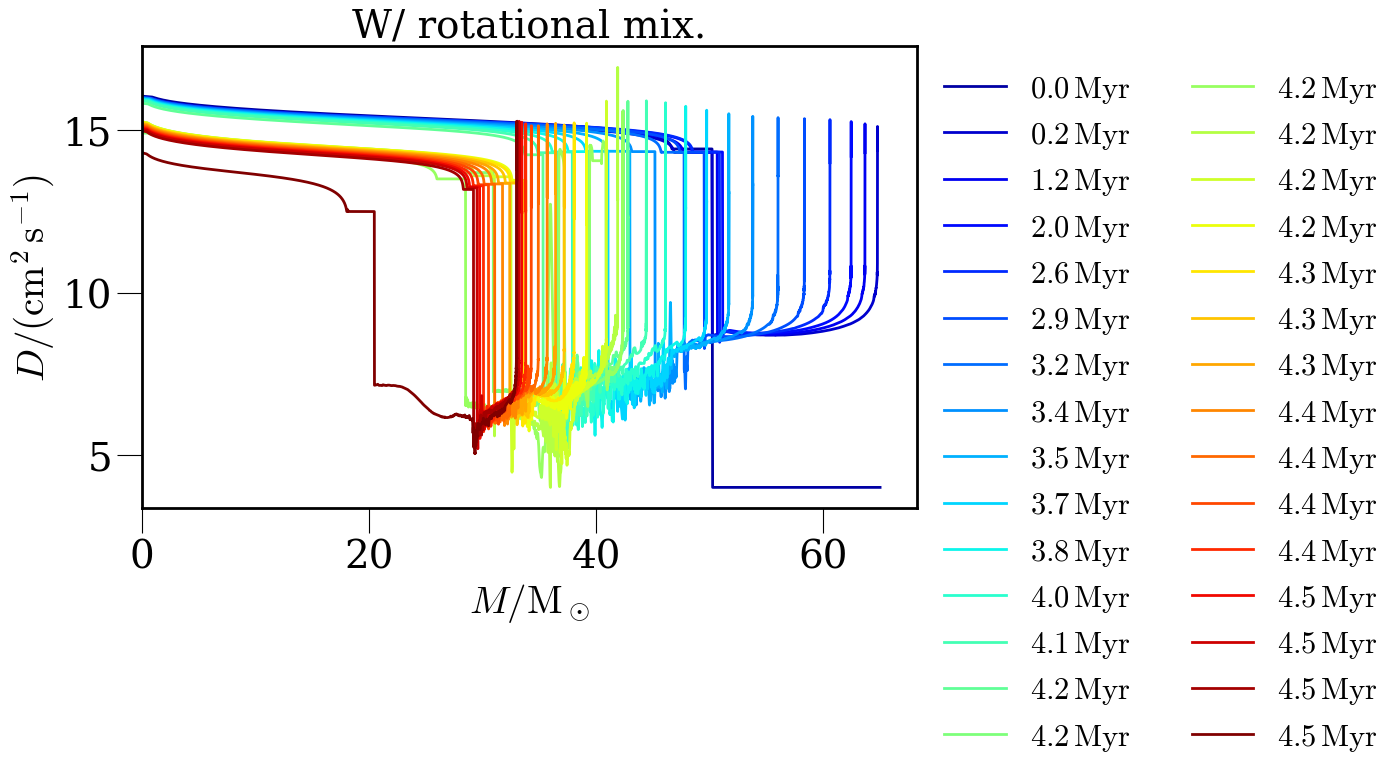

In [56]:
fig, ax = plt.subplots(figsize=(10,6))

for n in profile_numbers:
    c = cm.jet(n/len(profile_numbers))
    prof = logs.profile_data(profile_number=n)
    ax.plot(prof.mass, prof.log_D_mix, c=c, label=f'${prof.star_age/1e6:.1f}\\,\\mathrm{{Myr}}$', lw=2)
    ax.legend(loc='upper left', bbox_to_anchor=(1,1), frameon=False, ncol=2)
    ax.set_title('W/ rotational mix.')
    ax.set_xlabel('$M/\\mathrm{M}_\\odot$')
    ax.set_ylabel('$D/(\\mathrm{cm}^2\\,\\mathrm{s}^{-1})$')
    ax.set_xlim(0)
    
    

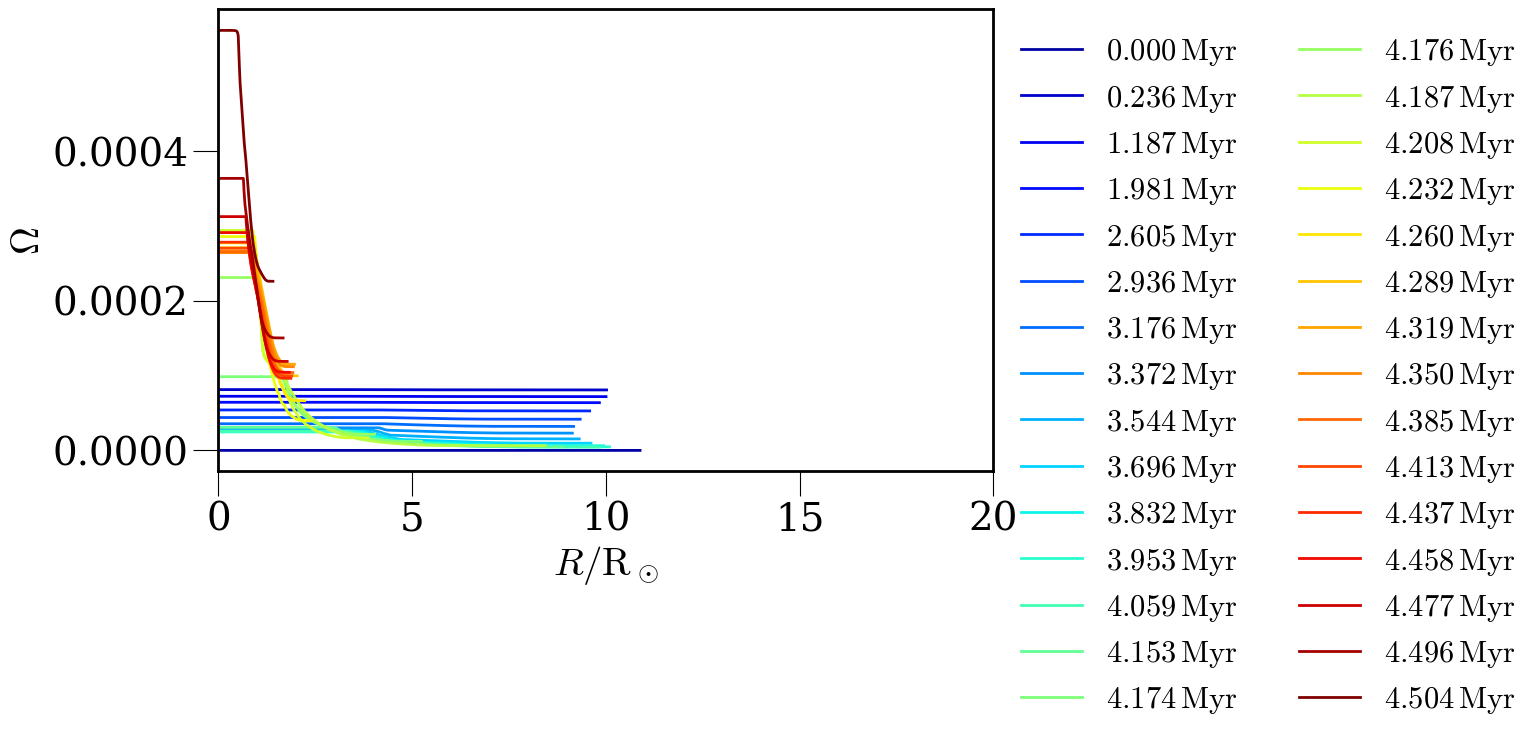

In [57]:
fig, ax = plt.subplots(figsize=(10,6))

for n in profile_numbers:
    c = cm.jet(n/len(profile_numbers))
    prof = logs.profile_data(profile_number=n)
    ax.plot(prof.radius, prof.omega, c=c, label=f'${prof.star_age/1e6:.3f}\\,\\mathrm{{Myr}}$', lw=2)
    ax.legend(loc='upper left', bbox_to_anchor=(1,1), frameon=False, ncol=2)
    #ax.set_title('W/ rotational mix.')
    ax.set_xlabel('$R/\\mathrm{R}_\\odot$')
    ax.set_ylabel('$\\Omega$')
    ax.set_xlim(0, 20)
    
    

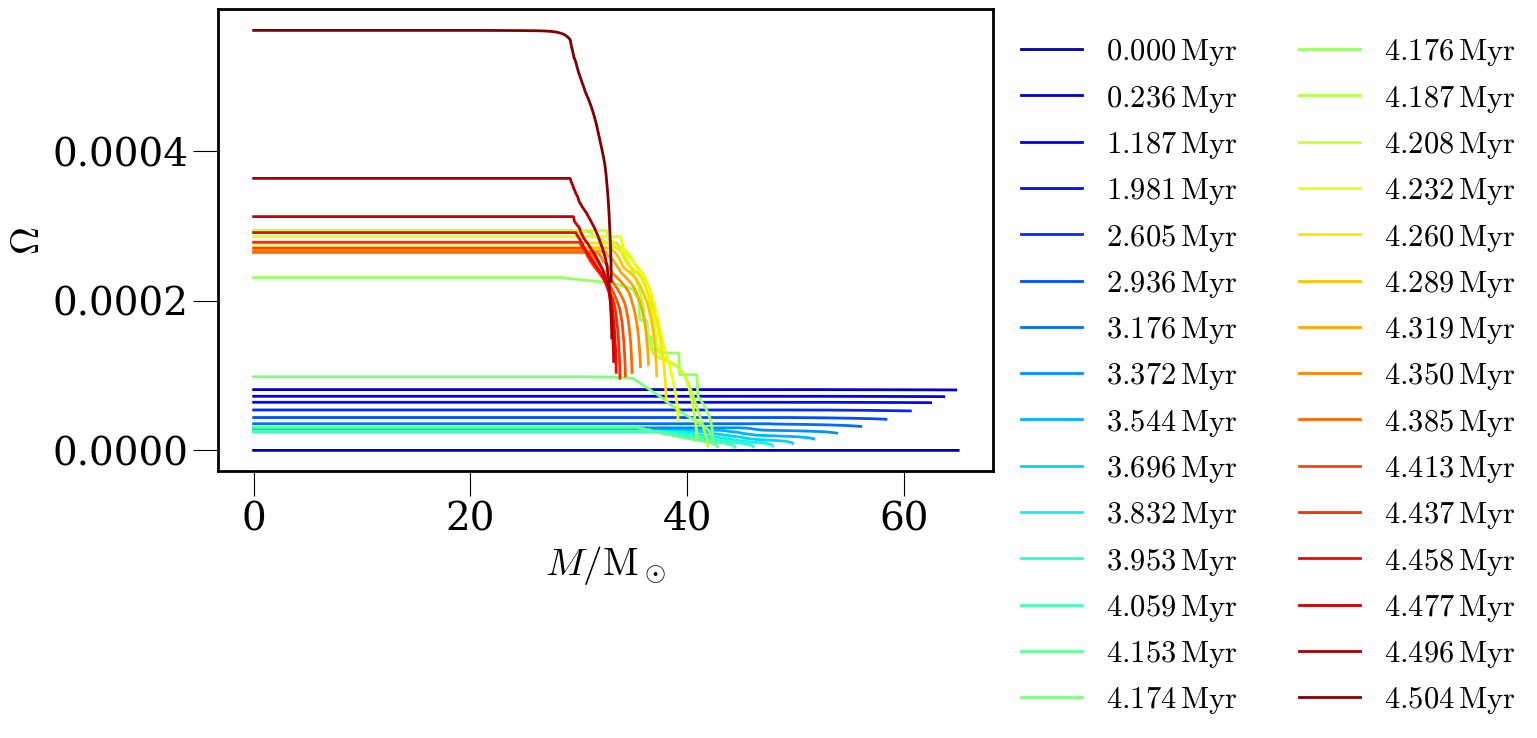

In [58]:
fig, ax = plt.subplots(figsize=(10,6))

for n in profile_numbers:
    c = cm.jet(n/len(profile_numbers))
    prof = logs.profile_data(profile_number=n)
    ax.plot(prof.mass, prof.omega, c=c, label=f'${prof.star_age/1e6:.3f}\\,\\mathrm{{Myr}}$', lw=2)
    ax.legend(loc='upper left', bbox_to_anchor=(1,1), frameon=False, ncol=2)
    #ax.set_title('W/ rotational mix.')
    ax.set_xlabel('$M/\\mathrm{M}_\\odot$')
    ax.set_ylabel('$\\Omega$')
    #ax.set_xlim(0, 20)
    
    

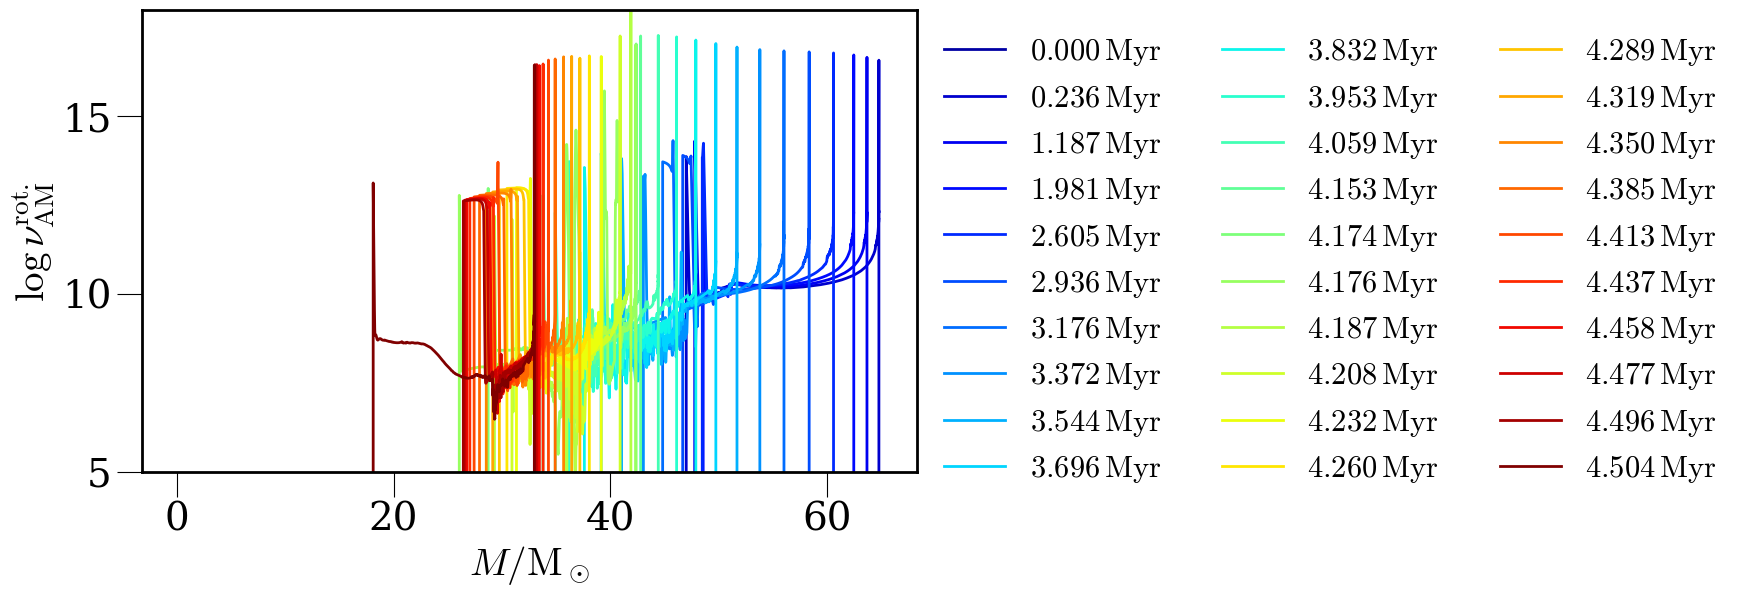

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))

for n in profile_numbers:
    c = cm.jet(n/len(profile_numbers))
    prof = logs.profile_data(profile_number=n)
    ax.plot(prof.mass, prof.log_am_nu_rot, c=c, label=f'${prof.star_age/1e6:.3f}\\,\\mathrm{{Myr}}$', lw=2)
    ax.legend(loc='upper left', bbox_to_anchor=(1,1), frameon=False, ncol=3)
    #ax.set_title('W/ rotational mix.')
    ax.set_xlabel('$M/\\mathrm{M}_\\odot$')
    ax.set_ylabel('$\\log\\nu_\\mathrm{AM}^\\mathrm{rot.}$')
    ax.set_ylim(5, 18)
    
    

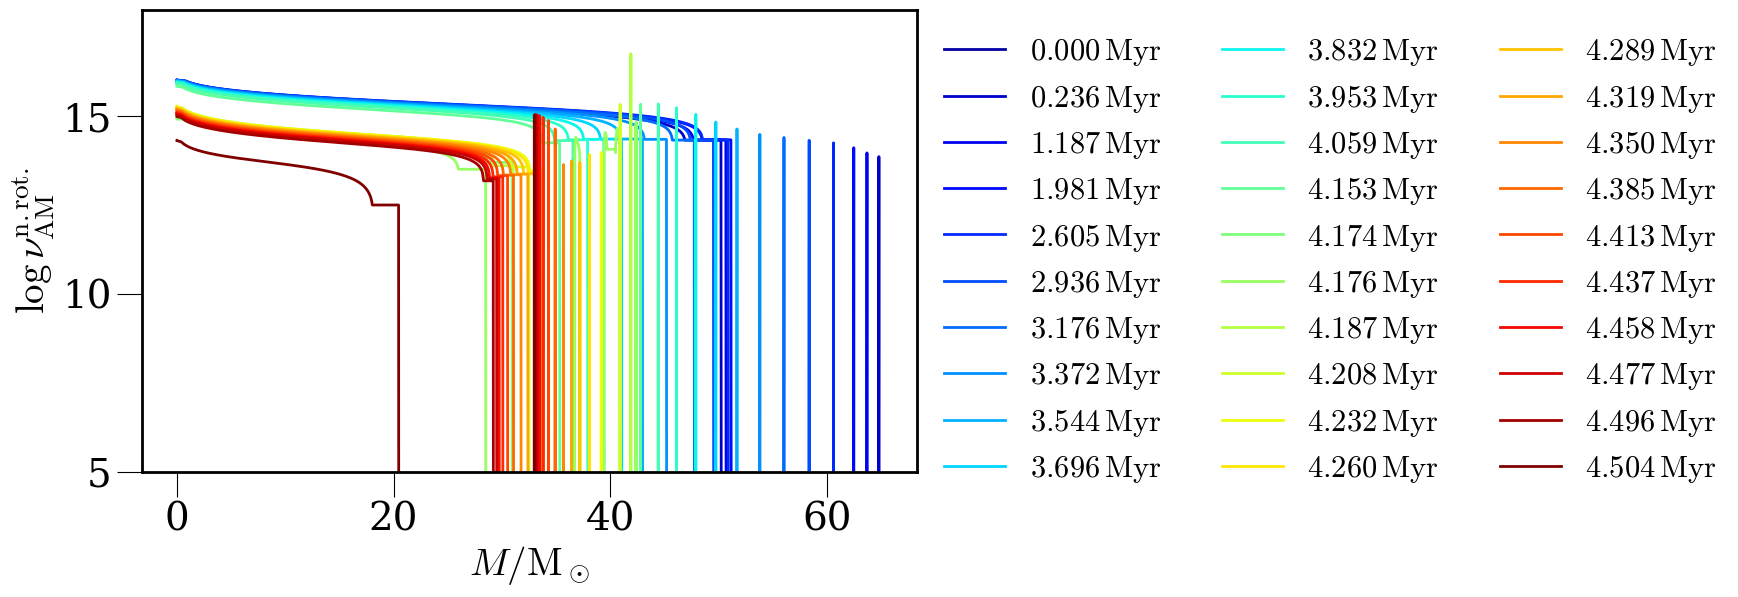

In [79]:
fig, ax = plt.subplots(figsize=(10,6))

for n in profile_numbers:
    c = cm.jet(n/len(profile_numbers))
    prof = logs.profile_data(profile_number=n)
    ax.plot(prof.mass, prof.log_am_nu_non_rot, c=c, label=f'${prof.star_age/1e6:.3f}\\,\\mathrm{{Myr}}$', lw=2)
    ax.legend(loc='upper left', bbox_to_anchor=(1,1), frameon=False, ncol=3)
    #ax.set_title('W/ rotational mix.')
    ax.set_xlabel('$M/\\mathrm{M}_\\odot$')
    ax.set_ylabel('$\\log\\nu_\\mathrm{AM}^\\mathrm{n.rot.}$')
    ax.set_ylim(5, 18)
    
    

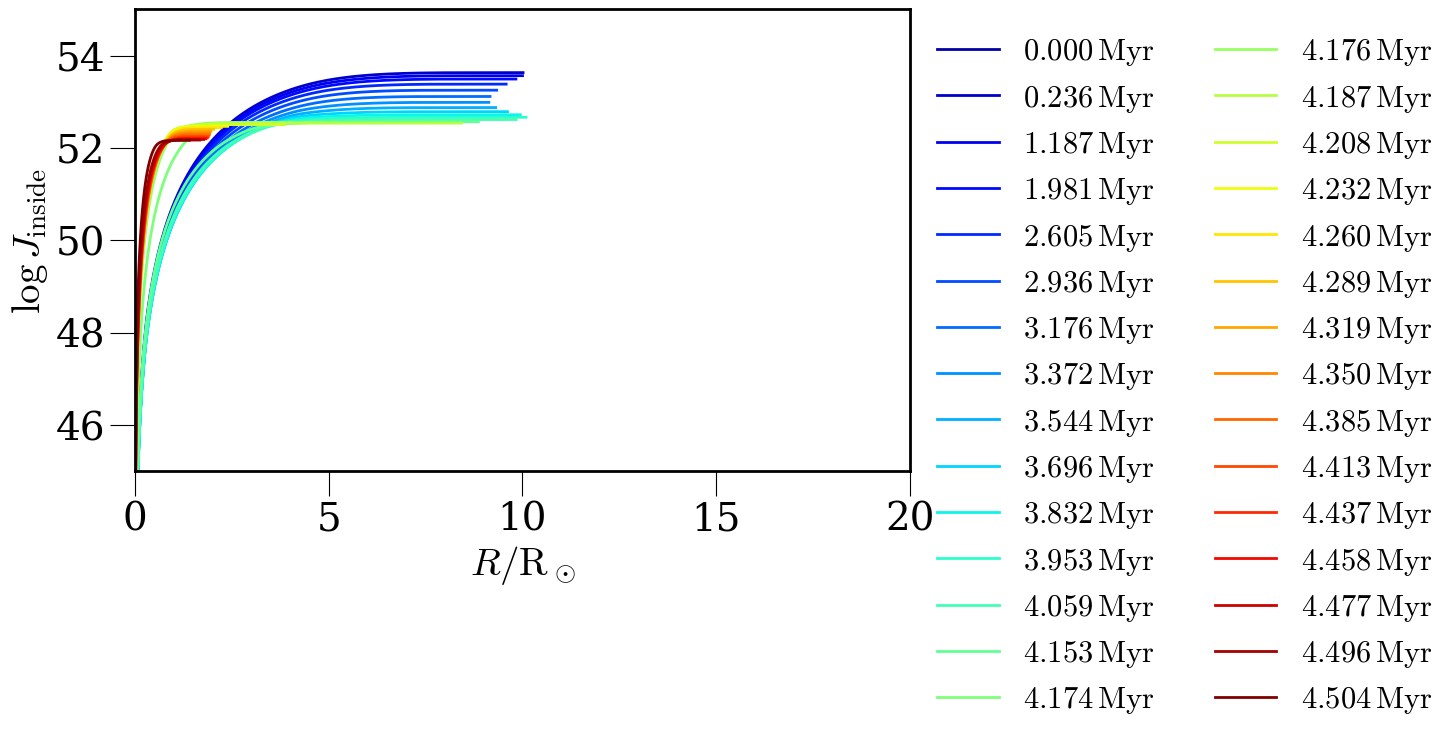

In [59]:
fig, ax = plt.subplots(figsize=(10,6))

for n in profile_numbers:
    c = cm.jet(n/len(profile_numbers))
    prof = logs.profile_data(profile_number=n)
    ax.plot(prof.radius, prof.log_J_inside, c=c, label=f'${prof.star_age/1e6:.3f}\\,\\mathrm{{Myr}}$', lw=2)
    ax.legend(loc='upper left', bbox_to_anchor=(1,1), frameon=False, ncol=2)
    #ax.set_title('W/ rotational mix.')
    ax.set_xlabel('$R/\\mathrm{R}_\\odot$')
    ax.set_ylabel('$\\log J_\\mathrm{inside}$')
    ax.set_ylim(45, 55)
    ax.set_xlim(0, 20)
    
    

In [62]:
tams_prof = logs.profile_data(profile_number=profile_numbers[-1])

In [63]:
w_center = tams_prof.omega[-1]
conv_core_r_index = np.where((w_center - tams_prof.omega)/w_center <= 0.1)[0][0]

In [64]:
core_logJ_tams = tams_prof.log_J_inside[conv_core_r_index]
core_mass_tams = tams_prof.mass[conv_core_r_index]

In [65]:
core_logJ_tams, core_mass_tams

(52.0520887859285, 29.965715228980862)

In [66]:
u.Msun.to(u.g)

1.988409870698051e+33

In [67]:
ct.c.cgs * (10**core_logJ_tams*u.g*u.cm**2/u.s) / ct.G.cgs / (core_mass_tams * u.Msun.to(u.g) * u.g)**2

<Quantity 1.42640433>

In [84]:
wind_test_model = model_dicts[0]['65.0']['0.80']

wind_test_h = mr.MesaData(str(wind_test_model/'LOGS/history.data'))

wind_test_omega = wind_test_h.surf_avg_omega_div_omega_crit
wind_test_start_i = np.where(wind_test_omega > 0)[0][0]

wind_test_l = 10.**wind_test_h.log_L[wind_test_start_i:]
wind_test_m = wind_test_h.star_mass[wind_test_start_i:]
wind_test_r = wind_test_h.radius[wind_test_start_i:]
wind_test_t = 10.**wind_test_h.log_Teff[wind_test_start_i:]
wind_test_y = wind_test_h.surface_he4[wind_test_start_i:]
wind_test_z = 0.0014

v01_winds = vink2001_winds(wind_test_l, wind_test_t, wind_test_m, wind_test_z)
v17_winds = vink2017_winds(wind_test_l, wind_test_z)
s23_winds = sanders_winds(wind_test_l, wind_test_z)
full_winds = winds(wind_test_l, wind_test_t, wind_test_m, wind_test_z, wind_test_y)

/tmp/ipykernel_1131897/508827619.py:14: RuntimeWarning: divide by zero encountered in log10
  ax0.plot(x, np.log10(s23_winds), 'm--', label='Sanders20,23 winds')
/tmp/ipykernel_1131897/508827619.py:107: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0)


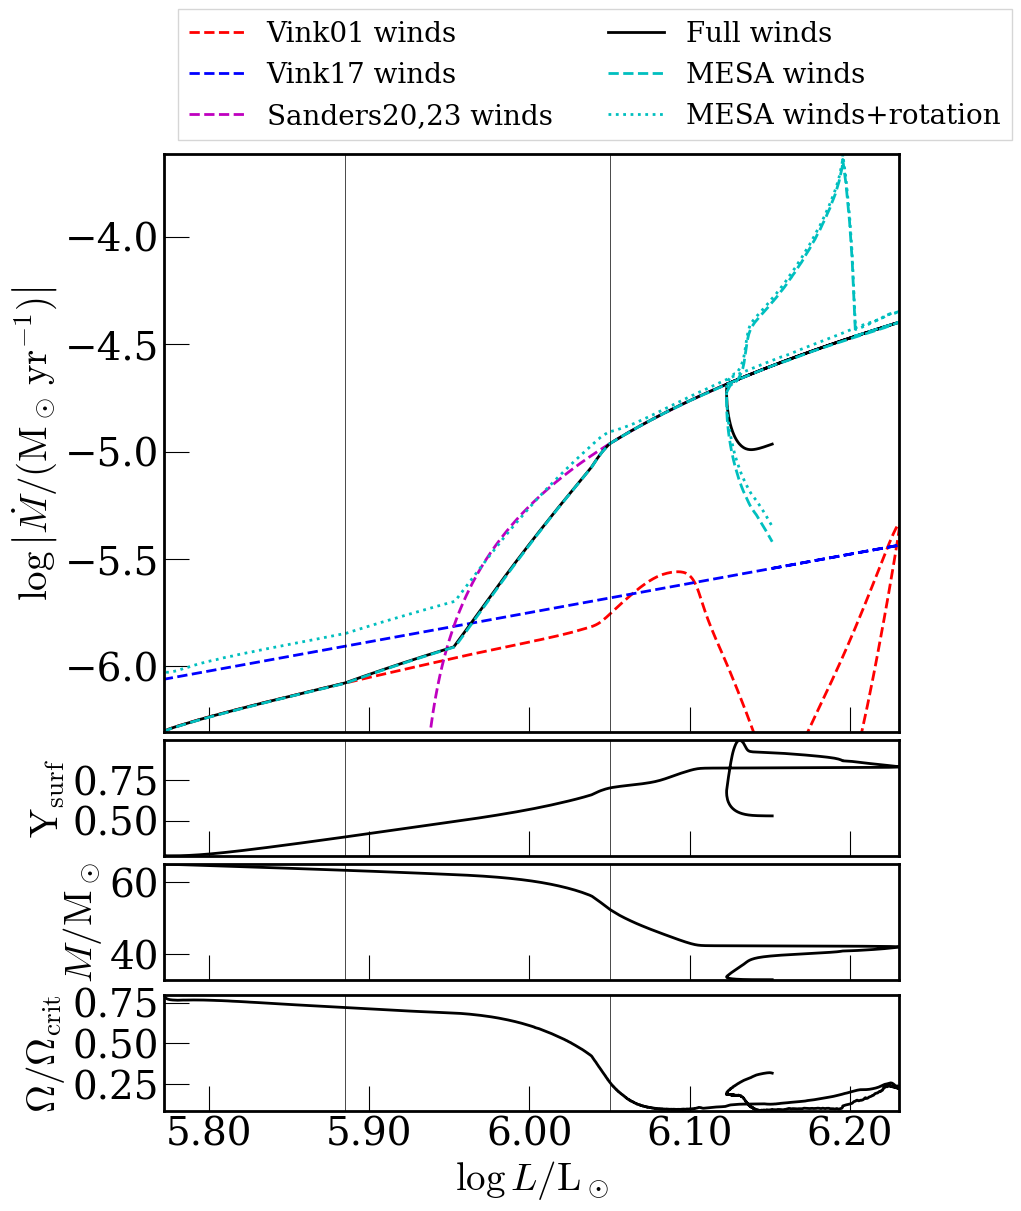

In [85]:
fig = plt.figure(figsize=(10, 12), layout='constrained')
gs = fig.add_gridspec(ncols=1, nrows=4, height_ratios=[1, 0.2, 0.2, 0.2], hspace=0)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[1,0])
ax2 = fig.add_subplot(gs[2,0])
ax3 = fig.add_subplot(gs[3,0])

x = np.log10(wind_test_l)
minx = min(x)
maxx = max(x)

ax0.plot(x, np.log10(v01_winds), 'r--', label='Vink01 winds')
ax0.plot(x, np.log10(v17_winds), 'b--', label='Vink17 winds')
ax0.plot(x, np.log10(s23_winds), 'm--', label='Sanders20,23 winds')
ax0.plot(x, np.log10(full_winds), 'k-', alpha=1, label='Full winds')

mesa_wind_rot = wind_test_h.log_abs_mdot[wind_test_start_i:]
mesa_wind = 10.**mesa_wind_rot
mesa_wind /= wind_test_h.rotational_mdot_boost[wind_test_start_i:]
mesa_wind = np.log10(mesa_wind)
miny = min(mesa_wind)
maxy = max(mesa_wind_rot)

ax0.plot(wind_test_h.log_L[wind_test_start_i:], mesa_wind, 'c--', label='MESA winds')
ax0.plot(wind_test_h.log_L[wind_test_start_i:], mesa_wind_rot, 'c:', label='MESA winds+rotation')

try: 
    y0_i = np.where(wind_test_h.surface_he4 >= 0.4)[0][0]
    y0_log_l = wind_test_h.log_L[y0_i]
except:
    y0_log_l = miny - 1
    
try:
    y1_i = np.where(wind_test_h.surface_he4 >= 0.7)[0][0]
    y1_log_l = wind_test_h.log_L[y1_i]
except:
    y0_log_l = maxy + 1
    
ax0.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax0.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
#ax0.text((y0_log_l+y1_log_l)/2, maxy-0.1, '$0.4<\\mathrm{Y}_\\mathrm{surf}<0.7$', ha='center', 
#         va='top', transform=ax0.transData, fontsize=16)

ax0.set_xlim(minx, maxx)
ax0.set_ylim(miny, maxy)
ax0.tick_params(direction='in')
ax0.set_xticklabels([])
ax0.set_ylabel('$\\log\\left|\\dot{M}/(\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1})\\right|$')
ax0.legend(frameon=True, fancybox=False, ncol=2, loc='lower left', bbox_to_anchor=(0, 1),
           fontsize=20)

## Surface He4

y = wind_test_h.surface_he4[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax1.plot(wind_test_h.log_L[wind_test_start_i:], y, color='k')

ax1.set_xticks(ax0.get_xticks())
ax1.set_xticklabels([])
ax1.set_xlim(ax0.get_xlim())

ax1.tick_params(direction='in')
ax1.set_ylabel('$\\mathrm{Y}_\\mathrm{surf}$')

ax1.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax1.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax1.set_ylim(miny, maxy)

## Mass

y = wind_test_h.star_mass[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax2.plot(wind_test_h.log_L[wind_test_start_i:], y, color='k')

ax2.set_xticks(ax0.get_xticks())
ax2.set_xticklabels([])
ax2.set_xlim(ax0.get_xlim())

ax2.tick_params(direction='in')
ax2.set_ylabel('$M/\\mathrm{M}_\\odot$')

ax2.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax2.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax2.set_ylim(miny, maxy)

# Surf avg omega/omega_crit

y = wind_test_h.surf_avg_omega_div_omega_crit[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax3.plot(wind_test_h.log_L[wind_test_start_i:], y, color='k')

ax3.set_xticks(ax0.get_xticks())
ax3.set_xticklabels([f'{t:.2f}' for t in ax3.get_xticks()])
ax3.set_xlim(ax0.get_xlim())

ax3.tick_params(direction='in')
ax3.set_ylabel('$\\Omega/\\Omega_\\mathrm{crit}$')
ax3.set_xlabel('$\\log L/\\mathrm{L}_\\odot$')

ax3.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax3.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax3.set_ylim(miny, maxy)

fig.subplots_adjust(hspace=0)

#savefig(fig, 'solar_280')

In [ ]:
models_to_plot = [0, 1, 2]

model_dict_list = model_dicts[models_to_plot]
model_label_list = model_labels[models_to_plot]
model_style_list = ['-', '--', ':']

settings = dict(
    x='center_he4',
    y='surface_he4',
    invert_xaxis=False,
    invert_yaxis=False,
    model_dict_list=model_dict_list,
    model_styles=model_style_list,
    model_labels=model_label_list
)


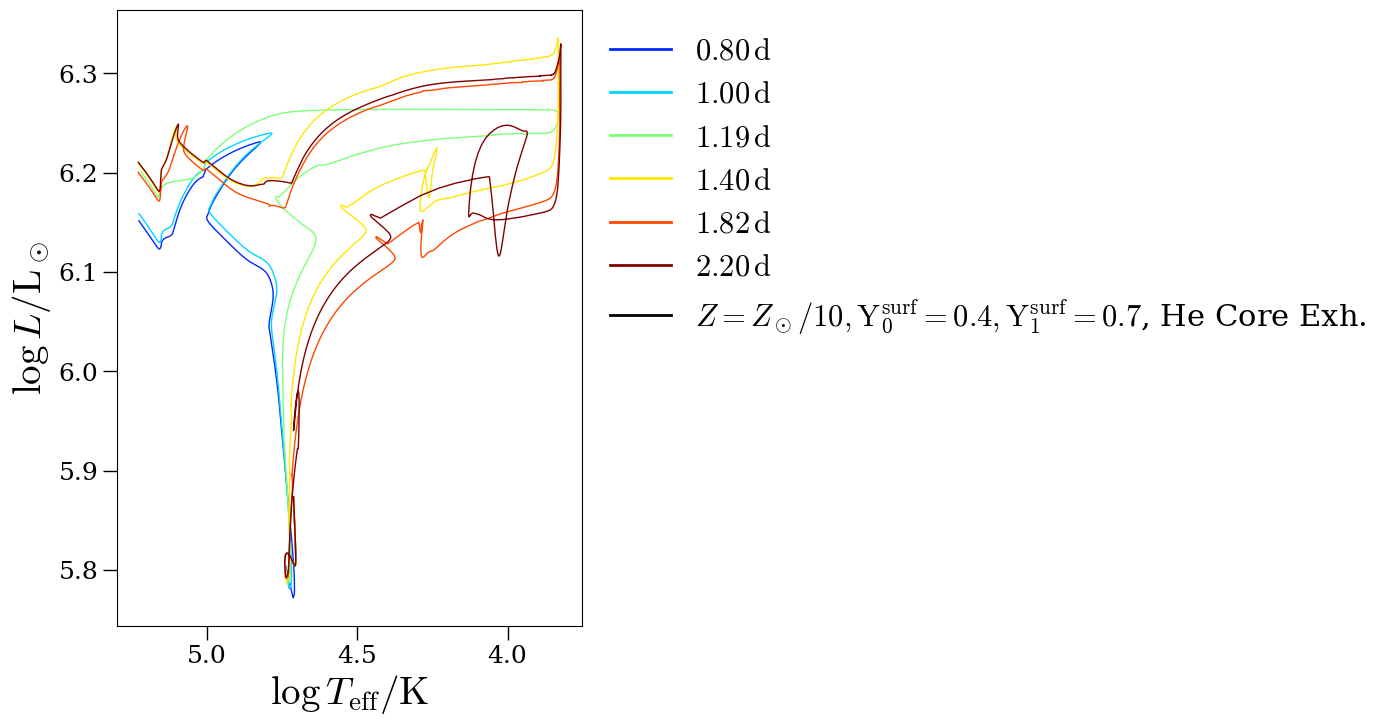

In [23]:
fig, ax = plt.subplots(figsize=(6, 8))

models_to_plot = [0]
model_dict_list = model_dicts[models_to_plot]
model_label_list = model_labels[models_to_plot]
model_style_list = ['-']

settings = dict(
    x='log_Teff',
    y='log_L',
    invert_xaxis=True,
    invert_yaxis=False,
    model_dict_list=model_dict_list,
    model_styles=model_style_list,
    model_labels=model_label_list,
)

ax = history_plot(ax, **settings)

ax.set_xlabel('$\\log T_\\mathrm{eff}/\\mathrm{K}$')
ax.set_ylabel('$\\log L/\\mathrm{L}_\\odot$')
#ax.set_xlim(5, 4.25)
#ax.set_ylim(5.75, 6.25)

savefig(fig, '10hr_allp')

In [24]:
mm = mp.MESA()
mm.loadHistory(f=str(model_dicts[0]['65.0']['0.80']/'LOGS'))
#mm.scrubHistory()

4933.0


ValueError: no field of name c_core_mass

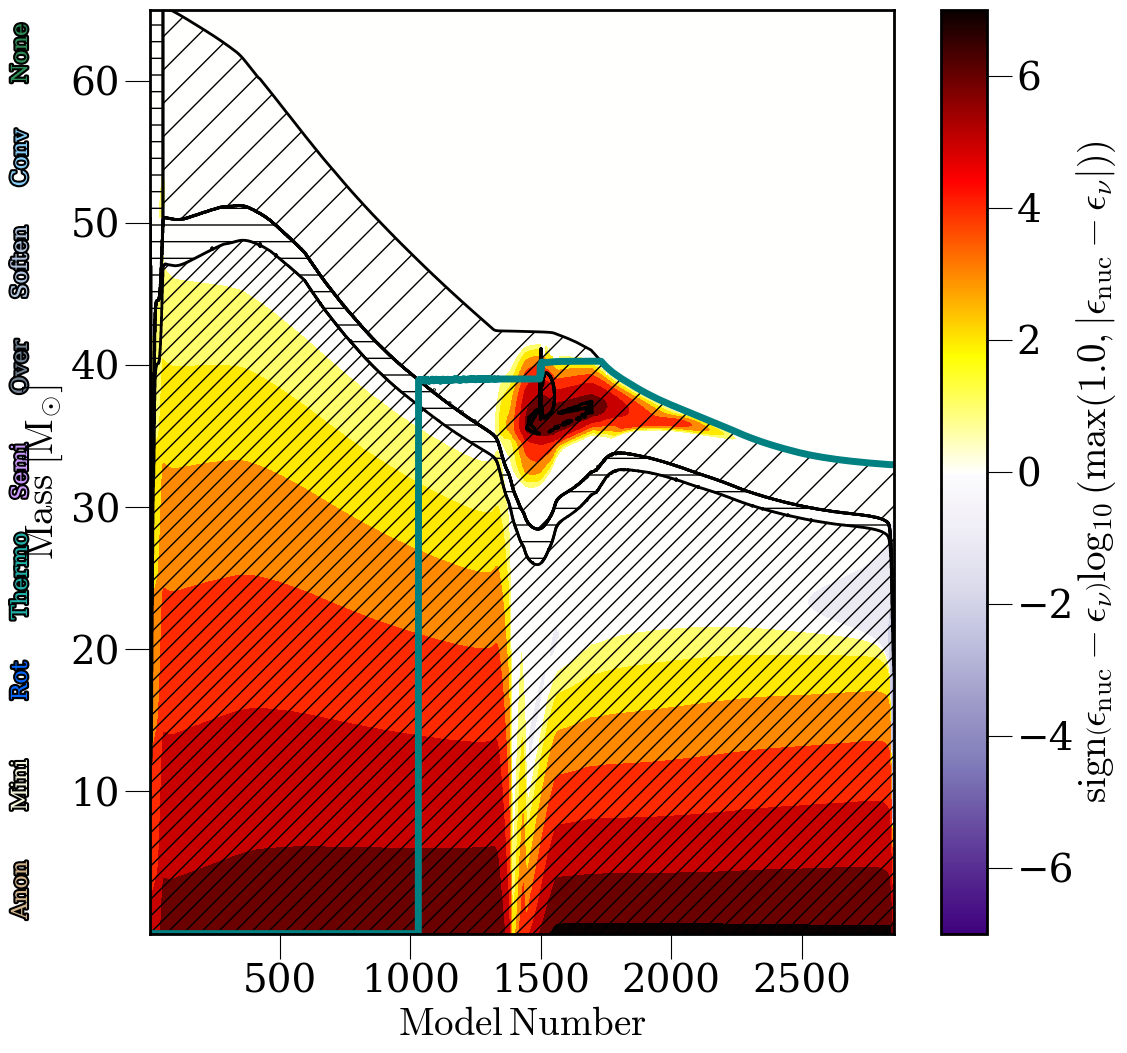

In [25]:
p = mp.plot()
p.plotKip(mm, show_mix=True, mix_hatch=True, show_mass_loc=True, step=1)

In [ ]:
mm = mp.MESA()
mm.loadHistory(f=str(model_dicts[0]['65.0']['1.19']/'LOGS'))
#mm.scrubHistory()

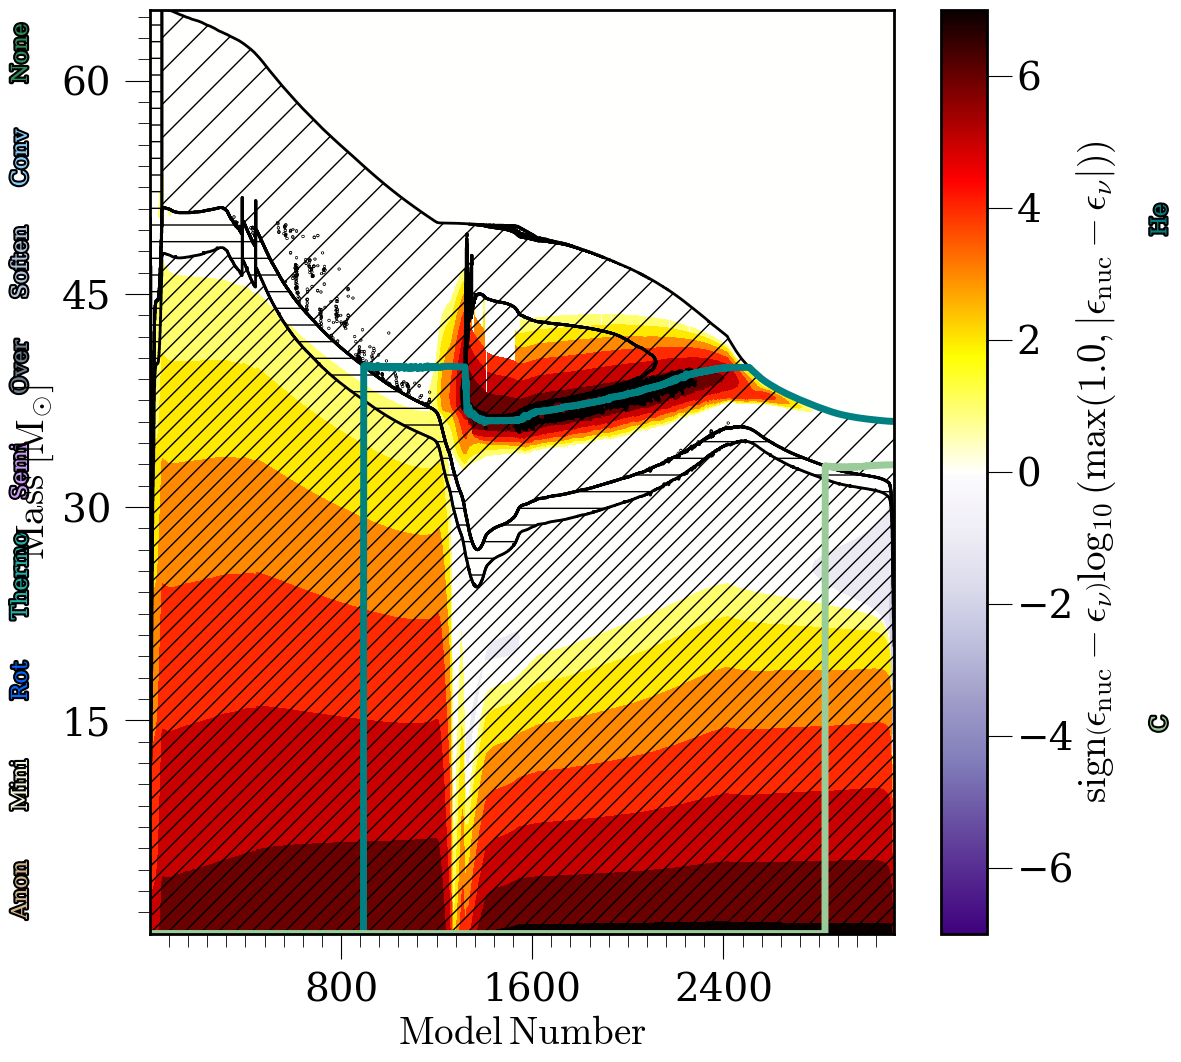

In [ ]:
p = mp.plot()
p.plotKip(mm, show_mix=True, mix_hatch=True, show_mass_loc=True, step=1)

In [ ]:
tp.chemical_profile(mm, time_ind=100)

/mnt/home/ldesa/repos/cher/mesa/sse_wind_test/10_m65_01_zsun_04y0_03dy_HeExh/m6.5d+01_w9.1d-05/LOGS//profile2.data


KeyboardInterrupt: 